### Imports

In [1]:
# ## Mount Google Drive Data (If using Google Colaboratory)
# try:
#     from google.colab import drive
#     drive.mount('/content/gdrive')
# except:
#     print("Mounting Failed.")

# Problem 1: Unsupervised Pre-training

### Training Hyperparameters

These are recommended hyperparameters - please feel free to use what works for you. Batch size can be changed if it does not match your memory, please state your batch step_size in your report.

In [2]:
## Standard Library
import os
import json

## External Libraries
import numpy as np

import torch
import torch.nn as nn
from torchvision import transforms
from torch.autograd import Variable
import torch.nn.functional as functional
from torch.utils.data import Dataset, DataLoader
from skimage import io
import matplotlib.pyplot as plt

### Data Paths

In [3]:
# General Data Directory ##TODO: Please fill in the appropriate directory
data_dir = "./HW6_data/"

## Segmentation + Colorization Paths
segmentation_data_dir = f"{data_dir}/segmentation/"
colorization_data_dir = f"{data_dir}/colorization/"

# Mask JSON
mask_json = f"{data_dir}/mapping.json"

### Data Loaders

We have provided you with some preprocessing code for the images but you should feel free to modify the class however you please to support your training schema. In the very least, you will have to modify the dataloader to support loading of the colorization dataset.

In [95]:
## Image Transforms
img_transform = transforms.Compose([
    transforms.ToTensor(),
])

## Image Dataloader
class ImageDataset(Dataset):

    """
    ImageDataset
    """

    def __init__(self, input_dir, op, mask_json_path, transforms=None):
        """
        ##TODO: Add support for colorization dataset

        Args:
            input_dir (str): Path to either colorization or segmentation directory
            op (str): One of "train", "val", or "test" signifying the desired split
            mask_json_path (str): Path to mapping.json file
            transforms (list or None): Image transformations to apply upon loading.
        """
        self.transform = transforms
        self.op = op
        with open(mask_json_path, 'r') as f:
            self.mask = json.load(f)
        self.mask_num = len(self.mask)  # There are 6 categories: grey, dark grey, and black
        self.mask_value = [value for value in self.mask.values()]
        self.mask_value.sort()
        try:
            if self.op == 'train':
                self.data_dir = os.path.join(input_dir, 'train')
            elif self.op == 'val':
                self.data_dir = os.path.join(input_dir, 'validation')
            elif self.op == 'test':
                self.data_dir = os.path.join(input_dir, 'test')
            elif self.op == 'train_cor':
                self.data_dir = os.path.join(input_dir, 'train_cor')
            elif self.op == 'val_cor':
                self.data_dir = os.path.join(input_dir, 'validation_cor')
        except ValueError:
            print('op should be either train, val or test!')

    def __len__(self):
        """
        """
        return len(next(os.walk(self.data_dir))[1])

    def __getitem__(self, idx):
        """

        """
        ## Load Image and Parse Properties
        if '_cor' in self.op:
            mask_name = str(idx) + '_gray.jpg'
        else:
            mask_name = str(idx) + '_mask.png'


        img_name = str(idx) + '_input.jpg'

        img = io.imread(os.path.join(self.data_dir, str(idx), img_name))
        mask = io.imread(os.path.join(self.data_dir, str(idx), mask_name))
        if len(mask.shape) == 2:
            h, w  = mask.shape
        elif len(mask.shape) == 3:
            h, w, c = mask.shape
        ## Convert grey-scale label to one-hot encoding
        new_mask = np.zeros((h, w, self.mask_num))
        for idx in range(self.mask_num):
            #if the mask has 3 dimension use this code
            # new_mask[:, :, idx] = mask[:,:,0] == self.mask_value[idx]
            #if the mask has 1 dimension use the code below
            new_mask[:, :, idx] = mask == self.mask_value[idx]
        ## Transform image and mask
        if self.transform:
            img, mask = self.img_transform(img, new_mask)
        # ## Use dictionary to output
        # sample = {'img': img, 'mask': mask}
        # return sample
        return img, mask

    def img_transform(self, img, mask):
        """

        """
        ## Apply Transformations to Image and Mask
        img = self.transform(img)
        # img = transforms.Grayscale(num_output_channels=1)(img)
        mask = self.transform(mask)
        return img, mask

## Model Architecture

Finish building the U-net architecture below.

In [5]:
## Functions for adding the convolution layer
def add_conv_stage(dim_in, dim_out, kernel_size=3, stride=1, padding=1, bias=True, useBN=True):
    """

    """
    # Use batch normalization
    if useBN:
        return nn.Sequential(
          nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.BatchNorm2d(dim_out),
          nn.LeakyReLU(0.1),
          nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.BatchNorm2d(dim_out),
          nn.LeakyReLU(0.1)
        )
    # No batch normalization
    else:
        return nn.Sequential(
          nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.ReLU(),
          nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.ReLU()
        )

## Upsampling
def upsample(ch_coarse, ch_fine):
    """

    """
    return nn.Sequential( nn.ConvTranspose2d(ch_coarse, ch_fine, 4, 2, 1, bias=False), nn.ReLU())


# U-Net
class UNET(nn.Module):

    """

    """
    def __init__(self,n_classes, useBN=True):
        """
        Args:
            useBN (bool): Turn Batch Norm on or off
        """
        super(UNET, self).__init__()
        # Downgrade stages
        self.conv1 = add_conv_stage(3, 32, useBN=useBN)
        self.conv2 = add_conv_stage(32, 64, useBN=useBN)
        self.conv3 = add_conv_stage(64, 128, useBN=useBN)
        self.conv4 = add_conv_stage(128, 256, useBN=useBN)
        # Upgrade stages
        self.conv3m = add_conv_stage(256, 128, useBN=useBN)
        self.conv2m = add_conv_stage(128,  64, useBN=useBN)
        self.conv1m = add_conv_stage( 64,  32, useBN=useBN)
        # Maxpool
        self.max_pool = nn.MaxPool2d(2)
        # Upsample layers
        self.upsample43 = upsample(256, 128)
        self.upsample32 = upsample(128,  64)
        self.upsample21 = upsample(64 ,  32)
        self.softmax = nn.Softmax(dim = 1)

        self.out = add_conv_stage(32, n_classes, kernel_size=1, stride=1, padding = 0, useBN=useBN)
        # weight initialization
        # I use Kaiming initialization to initialize the weight
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                if m.bias is not None:
                    m.bias.data.zero_()
                nn.init.kaiming_uniform_(m.weight.data)


    def forward(self, x):
        """
        Forward pass
        """
        conv1_out = self.conv1(x)
        conv2_out = self.conv2(self.max_pool(conv1_out))
        conv3_out = self.conv3(self.max_pool(conv2_out))
        conv4_out = self.conv4(self.max_pool(conv3_out))

        conv4m_out_ = torch.cat((self.upsample43(conv4_out), conv3_out), 1)
        conv3m_out  = self.conv3m(conv4m_out_)

        conv3m_out_ = torch.cat((self.upsample32(conv3m_out), conv2_out), 1)
        conv2m_out  = self.conv2m(conv3m_out_)

        conv2m_out_ = torch.cat((self.upsample21(conv2m_out), conv1_out), 1)
        conv1m_out  = self.conv1m(conv2m_out_)

        return self.softmax(self.out(conv1m_out))

### DICE Score and DICE Loss

Finish implementing the DICE score function below and then write a Dice Loss function that you can use to update your model weights.

In [6]:
##TODO: Finish implementing the multi-class DICE score function
def dice_score_image(prediction, target, n_classes):
    '''
      computer the mean dice score for a single image

      Reminders: A false positive is a result that indicates a given condition exists, when it does not
               A false negative is a test result that indicates that a condition does not hold, while in fact it does
      Args:
          prediction (tensor): predictied labels of the image
          target (tensor): ground truth of the image
          n_classes (int): number of classes

      Returns:
          m_dice (float): Mean dice score over classes
    '''
    ## TODO: Compute Dice Score for Each Class. Compute Mean Dice Score over Classes.
    dice_classes = np.zeros(n_classes)
    for cl in range(n_classes):
        target_flat = torch.squeeze(target)[cl].view(-1)
        prediction_flat = torch.squeeze(prediction)[cl].view(-1)
        if (target_flat == 1).sum() == 0:
          if (prediction_flat == 1).sum() ==0:
            dice_classes[cl] = 1
            continue
          else:
            dice_classes[cl]=0
            continue
        TP = (prediction_flat * target_flat).sum()
        FP =  prediction_flat.sum() - TP
        FN =  target_flat.sum() - TP
        #When there is no grount truth of the class in this image
        #Give 1 dice score if False Positive pixel number is 0,
        #give 0 dice score if False Positive pixel number is not 0 (> 0).
        dice_classes[cl] = (2 * TP) / (2 * TP + FP + FN)
    return dice_classes.mean()


def dice_score_dataset(model, dataloader, num_classes, use_gpu=False):
    """
    Compute the mean dice score on a set of data.

    Note that multiclass dice score can be defined as the mean over classes of binary
    dice score. Dice score is computed per image. Mean dice score over the dataset is the dice
    score averaged across all images.

    Reminders: A false positive is a result that indicates a given condition exists, when it does not
               A false negative is a test result that indicates that a condition does not hold, while in fact it does

    Args:
        model (UNET class): Your trained model
        dataloader (DataLoader): Dataset for evaluation
        num_classes (int): Number of classes

    Returns:
        m_dice (float): Mean dice score over the input dataset
    """
    ## Number of Batches and Cache over Dataset
    n_batches = len(dataloader)
    scores = np.zeros(n_batches)
    ## Evaluate
    model.eval()
    idx = 0
    for data in dataloader:
        ## Format Data
        img, target = data
        if use_gpu:
            img = img.cuda()
            target = target.cuda()
        ## Make Predictions
        out = model(img)
        n_classes = out.shape[1]
        prediction = torch.argmax(out, dim = 1)
        scatter_dim = len(prediction.size())

        y_tensor = prediction.view(*prediction.size(), -1)
        one_hot_pred= torch.zeros(*prediction.size(), num_classes).cuda()
        one_hot_pred = one_hot_pred.scatter(scatter_dim, y_tensor, 1)
        one_hot_pred = torch.transpose(one_hot_pred, 1,3)
        one_hot_pred = torch.transpose(one_hot_pred, 2,3)
        scores[idx] = dice_score_image(one_hot_pred, target, n_classes)

        idx += 1
    ## Average Dice Score Over Images
    m_dice = scores.mean()
    return m_dice


## TODO: Implement DICE loss,
#  It should conform to to how we computer the dice score.
class DICELoss(nn.Module):
    def __init__(self):
      super(DICELoss, self).__init__()

    def forward(self, predict, target):
      dice = (2 * (predict * target).sum((2, 3))) / (predict.sum((2, 3)) + target.sum((2, 3)))
      dice = dice.mean()
      return 1 - dice

In [7]:
use_gpu = torch.cuda.is_available()

## Training Procedure (Segmentation)

In [8]:
## Batch Size
train_batch_size = 10
validation_batch_size = 10

## Learning Rate
learning_rate = 1e-3

# Epochs (Consider setting high and implementing early stopping)
num_epochs = 200

In [9]:
## Initialize your unet
n_classes = 6
model = UNET(n_classes)

## Initialize Dataloaders
train_dataset=ImageDataset(input_dir=segmentation_data_dir, op="train", mask_json_path=mask_json, transforms=img_transform)
validation_dataset=ImageDataset(input_dir=segmentation_data_dir, op="val", mask_json_path=mask_json, transforms=img_transform)
test_dataset=ImageDataset(input_dir=segmentation_data_dir, op="test", mask_json_path=mask_json, transforms=img_transform)

train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=10, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

## Initialize Optimizer and Learning Rate Scheduler
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

model = model.cuda()

training_loss = []
validation_loss = []


print("Start Training...")
for epoch in range(num_epochs):
    ########################### Training #####################################
    model.train()
    print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
    train_loss = 0.0
    val_loss = 0.0
    for data in train_dataloader:
        optimizer.zero_grad()
        inputs, target = data
        inputs = inputs.cuda()
        target = target.cuda()
        output = model(inputs)

        loss = DICELoss()(output,target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_dataloader)

    training_loss.append(train_loss)
    scheduler.step()

    ########################### Validation #####################################
    model.eval()
    for data in validation_dataloader:
        inputs, target = data
        inputs = inputs.cuda()

        target = target.cuda()
        output = model(inputs)

        loss = DICELoss()(output,target)
        val_loss += loss.item()

    val_loss /= len(validation_dataloader)
    validation_loss.append(val_loss)

    print('Training loss: {}, validation loss: {}'.format(train_loss, val_loss))

Start Training...

EPOCH 1 of 200

Training loss: 0.8990681788655933, validation loss: 0.8914063928326442

EPOCH 2 of 200

Training loss: 0.8752729864377928, validation loss: 0.8743271931830598

EPOCH 3 of 200

Training loss: 0.8564506692471991, validation loss: 0.850217030647227

EPOCH 4 of 200

Training loss: 0.8433881879619519, validation loss: 0.8384836733759208

EPOCH 5 of 200

Training loss: 0.8353607949620394, validation loss: 0.8354542241324385

EPOCH 6 of 200

Training loss: 0.8276544373664432, validation loss: 0.8307254779124256

EPOCH 7 of 200

Training loss: 0.8244885831766214, validation loss: 0.8662277032692203

EPOCH 8 of 200

Training loss: 0.8209793979043424, validation loss: 0.822990787340764

EPOCH 9 of 200

Training loss: 0.8133045465226882, validation loss: 0.8094934172965644

EPOCH 10 of 200

Training loss: 0.8032122273387503, validation loss: 0.8090926007703395

EPOCH 11 of 200

Training loss: 0.7999846480544472, validation loss: 0.8179567307940164

EPOCH 12 of 2

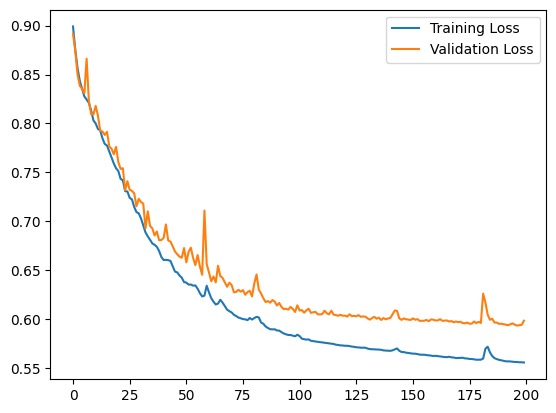

In [10]:
plt.plot(training_loss, label="Training Loss")
plt.plot(validation_loss, label="Validation Loss")
plt.legend()
plt.show()

In [11]:
dice_score_dataset(model, test_dataloader, 6, True)

0.5555680896218718

## Data Augmentation

In [12]:
img_transform_new = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.1),
    transforms.RandomVerticalFlip(p=0.1),
])

In [13]:
## Initialize your unet
n_classes = 6
model = UNET(n_classes)
learning_rate = 5e-3

## Initialize Dataloaders
train_dataset=ImageDataset(input_dir=segmentation_data_dir, op="train", mask_json_path=mask_json, transforms=img_transform_new)
validation_dataset=ImageDataset(input_dir=segmentation_data_dir, op="val", mask_json_path=mask_json, transforms=img_transform_new)
test_dataset=ImageDataset(input_dir=segmentation_data_dir, op="test", mask_json_path=mask_json, transforms=img_transform_new)

train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=10, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

## Initialize Optimizer and Learning Rate Scheduler
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

model = model.cuda()

training_loss = []
validation_loss = []


print("Start Training...")
for epoch in range(num_epochs):
    ########################### Training #####################################
    model.train()
    print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
    train_loss = 0.0
    val_loss = 0.0
    for data in train_dataloader:
        optimizer.zero_grad()
        inputs, target = data
        inputs = inputs.cuda()
        target = target.cuda()
        output = model(inputs)

        loss = DICELoss()(output,target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_dataloader)

    training_loss.append(train_loss)
    scheduler.step()

    ########################### Validation #####################################
    model.eval()
    for data in validation_dataloader:
        inputs, target = data
        inputs = inputs.cuda()

        target = target.cuda()
        output = model(inputs)

        loss = DICELoss()(output,target)
        val_loss += loss.item()

    val_loss /= len(validation_dataloader)
    validation_loss.append(val_loss)

    print('Training loss: {}, validation loss: {}'.format(train_loss, val_loss))

Start Training...

EPOCH 1 of 200

Training loss: 0.8961580120514565, validation loss: 0.8730603870996247

EPOCH 2 of 200

Training loss: 0.8749940728773994, validation loss: 0.8624093951554335

EPOCH 3 of 200

Training loss: 0.861063514580388, validation loss: 0.8509114660091607

EPOCH 4 of 200

Training loss: 0.8463810261385561, validation loss: 0.860251407935138

EPOCH 5 of 200

Training loss: 0.8419113280858979, validation loss: 0.8600564036715733

EPOCH 6 of 200

Training loss: 0.8253279724009615, validation loss: 0.888076878645226

EPOCH 7 of 200

Training loss: 0.8221582327705558, validation loss: 0.8168328593761551

EPOCH 8 of 200

Training loss: 0.8090897764546973, validation loss: 0.7929478349625645

EPOCH 9 of 200

Training loss: 0.8020768581736968, validation loss: 0.7842355838290013

EPOCH 10 of 200

Training loss: 0.7938121851625456, validation loss: 0.7951983332241457

EPOCH 11 of 200

Training loss: 0.7862704278761501, validation loss: 0.79714735110348

EPOCH 12 of 200


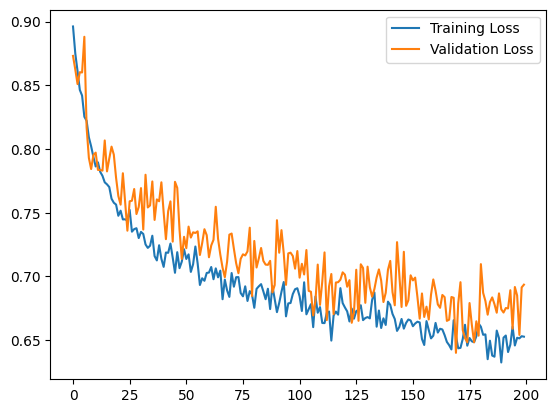

In [14]:
plt.plot(training_loss, label="Training Loss")
plt.plot(validation_loss, label="Validation Loss")
plt.legend()
plt.show()

In [15]:
dice_score_dataset(model,test_dataloader, 6, True)

0.48890744588357415

## Training Procedure: Colorization Pre-training

Complete the rest of this problem in the cells below.

In [93]:
## Batch Size
train_batch_size = 256
validation_batch_size = 256

## Learning Rate
learning_rate = 5e-2

# Epochs (Consider setting high and implementing early stopping)
num_epochs = 5

In [ ]:
## Initialize your unet
n_classes = 6
color_model = UNET(n_classes)

## Initialize Dataloaders
color_train_dataset = ImageDataset(input_dir=colorization_data_dir, op="train_cor", mask_json_path=mask_json, transforms=img_transform)
color_validation_dataset = ImageDataset(input_dir=colorization_data_dir, op="val_cor", mask_json_path=mask_json, transforms=img_transform)
# color_test_dataset=ImageDataset(input_dir=colorization_data_dir, op="test", mask_json_path=mask_json, transforms=img_transform)

color_train_dataloader = DataLoader(color_train_dataset, batch_size=10, shuffle=True)
color_validation_dataloader = DataLoader(color_validation_dataset, batch_size=10, shuffle=False)
# color_test_dataloader = DataLoader(color_test_dataset, batch_size=1, shuffle=False)

## Initialize Optimizer and Learning Rate Scheduler
optimizer = torch.optim.Adam(color_model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

color_model = color_model.cuda()

training_loss = []
validation_loss = []


print("Start Training...")
for epoch in range(num_epochs):
    ########################### Training #####################################
    color_model.train()
    print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
    train_loss = 0.0
    val_loss = 0.0
    for data in color_train_dataloader:
        optimizer.zero_grad()
        inputs, target = data
        inputs = inputs.cuda()
        target = target.cuda()
        output = color_model(inputs)

        loss = DICELoss()(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(color_train_dataloader)

    training_loss.append(train_loss)
    scheduler.step()

    ########################### Validation #####################################
    color_model.eval()
    for data in color_validation_dataloader:
        inputs, target = data
        inputs = inputs.cuda()

        target = target.cuda()
        output = model(inputs)

        loss = DICELoss()(output, target)
        val_loss += loss.item()

    val_loss /= len(color_validation_dataloader)
    validation_loss.append(val_loss)

    print('Training loss: {}, validation loss: {}'.format(train_loss, val_loss))

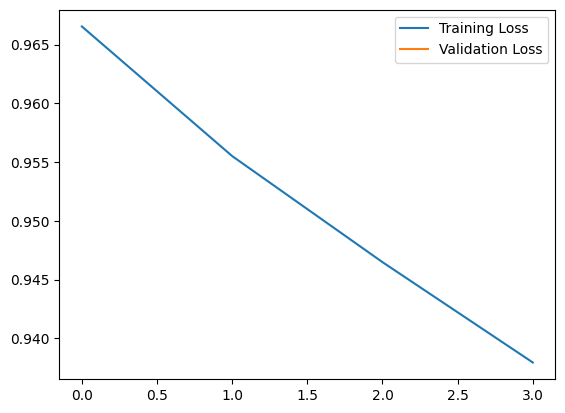

In [87]:
plt.plot(training_loss, label="Training Loss")
plt.plot(validation_loss, label="Validation Loss")
plt.legend()
plt.show()

In [98]:
torch.save(color_model, 'color_model.pth')

# model = torch.load('model.pth')
# model.eval()

# Problem 2: Transfer Learning

### Imports

In [53]:
## Import VGG and FashionMNIST
from torchvision.models import vgg16
from torchvision.datasets import FashionMNIST

### Data Loading

In [54]:
## Specify Batch Size
train_batch_size = 256
test_batch_size = 256

## Specify Image Transforms
img_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

## Download Datasets
train_data = FashionMNIST('./data', transform=img_transform, download=True, train=True)
test_data = FashionMNIST('./data', transform=img_transform, download=True, train=False)

## Initialize Dataloaders
train_dataloader = DataLoader(train_data, batch_size=train_batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=test_batch_size, shuffle=True)

### Model Initialization and Training/Fine-tuning

Complete the rest of the assignment in the notebook below.

(a) Randomly initialize all parameters in VGG16 and try to train your model to learn the
Fashion MNIST classification task. What’s the accuracy you achieve? Please report
your test accuracy on the test dataset. You should expect an accuracy > 85%

In [55]:
model = vgg16(pretrained=False)

model.classifier[6].out_features = 10
model.features[0] = nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size = 3)

In [56]:
def kaiming_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

model.apply(kaiming_init)

VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fals

In [57]:
if use_gpu:
    model = model.cuda()

In [58]:
def calc_accuracy(true_y, pred_y):
    """
    """
    true_prediction_num = 0
    for i, py in enumerate(pred_y):
        if py == true_y[i]:
            true_prediction_num += 1
    accuracy = true_prediction_num / len(pred_y)
    return accuracy

In [59]:
training_loss = []

loss_f = nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
epochs = 10

In [60]:
print("Start Training...")
for epoch in range(epochs):
    ########################### Training #####################################
    model.train()
    print("\nEPOCH " +str(epoch+1)+" of "+str(epochs)+"\n")
    train_loss = 0.0
    for data in train_dataloader:
        optimizer.zero_grad()
        inputs, target = data
        inputs = inputs.cuda()
        target = target.cuda()
        output = model(inputs)

        loss = loss_f(output,target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_dataloader)

    training_loss.append(train_loss)
    print('Training loss: {}'.format(train_loss))

Start Training...

EPOCH 1 of 10

Training loss: 1.5759453451379817

EPOCH 2 of 10

Training loss: 0.37123939318859833

EPOCH 3 of 10

Training loss: 0.2959898520657357

EPOCH 4 of 10

Training loss: 0.25504293930023275

EPOCH 5 of 10

Training loss: 0.2265735072975463

EPOCH 6 of 10

Training loss: 0.21567399543016516

EPOCH 7 of 10

Training loss: 0.1889711542966518

EPOCH 8 of 10

Training loss: 0.1743955302111646

EPOCH 9 of 10

Training loss: 0.17194702156046604

EPOCH 10 of 10

Training loss: 0.15608335178583227


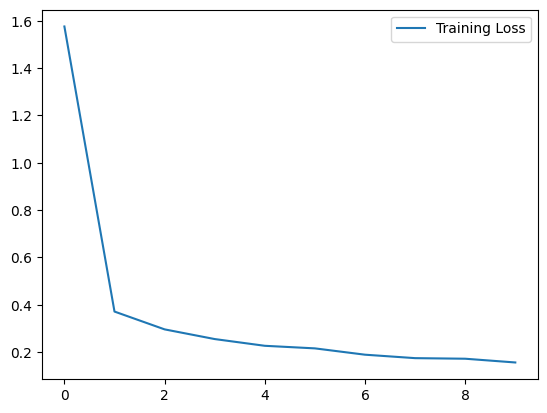

In [61]:
plt.plot(training_loss, label="Training Loss")
plt.legend()
plt.show()

In [62]:
y_pred_test = []
y_true_test = []

for data in test_dataloader:
    inputs, target = data
    if use_gpu:
        inputs = inputs.cuda()
        target = target.cuda()
    output = model(inputs)

    y_pred_test.extend(output.cpu().argmax(dim=1, keepdim=True).detach().numpy())
    y_true_test.extend(target.cpu().detach().numpy())

test_accuracy = calc_accuracy(y_true_test, y_pred_test)

In [63]:
print("Test Accuracy: {}".format(test_accuracy))

Test Accuracy: 0.9139


(b) Load the pre-trained VGG16 model from torch vision models. Freeze all but the last
layer: randomly initialize the last layer of your network and fine-tune this. What
accuracy do you get now? Please again report your test accuracy on the test dataset.
You should expect an accuracy > 60%.

In [64]:
model = vgg16(pretrained=True)
model.classifier[6].out_features = 10
model.features[0] = nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size = 3)

epochs = 5

for param in model.parameters():
  param.require_grad = False

model.classifier[6].require_grad = True

model.classifier[6].apply(kaiming_init)

model=model.cuda()

loss_f = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

C:\Users\10754\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\10754/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100%|██████████| 528M/528M [00:08<00:00, 67.6MB/s] 


In [66]:
training_loss = []

In [67]:
print("Start Training...")
for epoch in range(epochs):
    ########################### Training #####################################
    model.train()
    print("\nEPOCH " +str(epoch+1)+" of "+str(epochs)+"\n")
    train_loss = 0.0
    for data in train_dataloader:
        optimizer.zero_grad()
        inputs, target = data
        inputs = inputs.cuda()
        target = target.cuda()
        output = model(inputs)

        loss = loss_f(output,target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_dataloader)

    training_loss.append(train_loss)
    print('Training loss: {}'.format(train_loss))

Start Training...

EPOCH 1 of 5

Training loss: 1.8679259071958827

EPOCH 2 of 5

Training loss: 0.4864376690793545

EPOCH 3 of 5

Training loss: 0.37622451338362184

EPOCH 4 of 5

Training loss: 0.2981575707171826

EPOCH 5 of 5

Training loss: 0.25535979321662416


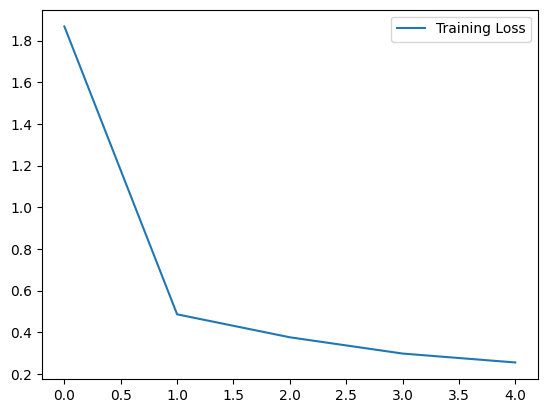

In [70]:
plt.plot(training_loss, label="Training Loss")
plt.legend()
plt.show()

In [69]:
y_pred_test = []
y_true_test = []
for data in test_dataloader:
  inputs, target = data
  if use_gpu:
    inputs = inputs.cuda()
    target = target.cuda()
  output = model(inputs)

  y_pred_test.extend(output.cpu().argmax(dim=1, keepdim=True).detach().numpy())
  y_true_test.extend(target.cpu().detach().numpy())

test_accuracy = calc_accuracy(y_true_test, y_pred_test)

print("Test accuracy: {}".format(test_accuracy))

Test accuracy: 0.8942


(c) Now, imagine a scenario in which you want to train the VGG16 model on an entirely
new dataset and will fine-tune either the model from (2a) or (2b). Which pre-trained
model is the preferred starting point for your new use case?

For most new datasets and tasks, especially those related to general image classification, the preferred starting point would be the model fine-tuned with pre-trained weights (as in 2b). This is because the features learned from ImageNet are broadly applicable to a wide range of visual recognition tasks.

Moreover, fine-tuning a pre-trained network often leads to better performance when compared to a network trained from scratch, as the pre-trained network can leverage knowledge (features, patterns, etc.) learned from the large and diverse ImageNet dataset, which often translates into a better generalization on new tasks.